# Data Preprocessing

## Import the libraries

In [1]:
!pip install ibm-cos-sdk | grep -v 'already satisfied'
import ibm_boto3
from ibm_botocore.client import Config
import pandas as pd
import numpy as np
import io, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.12.0-py3-none-any.whl size=73931 sha256=b01faf20ad34c63656c7a75e9fc8808f3e7b2ad03be67c55a8e09fac8ba6ce77
  Stored in directory: /root/.cache/pip/wheels/ec/94/29/2b57327cf00664b6614304f7958abd29d77ea0e5bbece2ea57
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.12.0-py3-none-any.whl size=562962 sha256=23a2f3ad09dbba8445ad22be7215525935ea9b2e9dce6b966201764f36ea00db
  Stored in directory: /root/.cache/pip/wheels/64/56/fb/5cd6f4f40406c828a5289b95b2752a4d142a9afb359244ed8d
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.12.0-py3-none-any.whl size=89778 sha256=a35b0c4f8fff85b8a542031ae08ddd55b0da9d5291a12885f2f886c890c4ddb7
  Stored in directory: /root/.cache/pip/wheels/57/79/6a/ffe3370ed7ebc00604f9f76766e1e0348dcdcad2b2e32df9e1
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3tr

## Importing the dataset

In [6]:
cos_credentials={
  "apikey": "5lDfM8QcqpTFlKVVjKmm06zGbSspFR6gqGpmbFDWLlRc",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297:resource-key:cd3a6762-cdaf-4808-b931-198e378e86d5",
  "iam_apikey_name": "pnt2022tmid13214",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/d2c796b84a794b58a1cff48368133ea1::serviceid:ServiceId-469be452-375b-4d58-9c23-d742c9a3256e",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297::"
}
auth_endpoint = 'https://iam.cloud.ibm.com/oidc/token'
service_endpoint = 'https://s3.us-east.cloud-object-storage.appdomain.cloud'
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)
obj =cos.get_object(Bucket='pnt2022tmid13214', Key='Crude Oil Prices Daily.xlsx')
df = pd.read_excel(io.BytesIO(obj['Body'].read()), header=None, names=['date', 'price'] ,skiprows=1)
df.head()

,date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


## Handling missing data

In [3]:
df.isnull().any()

date     False
price     True
dtype: bool

In [4]:
df.dropna(axis=0,inplace=True)
df.isnull().any()

date     False
price    False
dtype: bool

In [7]:
df.shape

(8223, 2)

## Data visualization

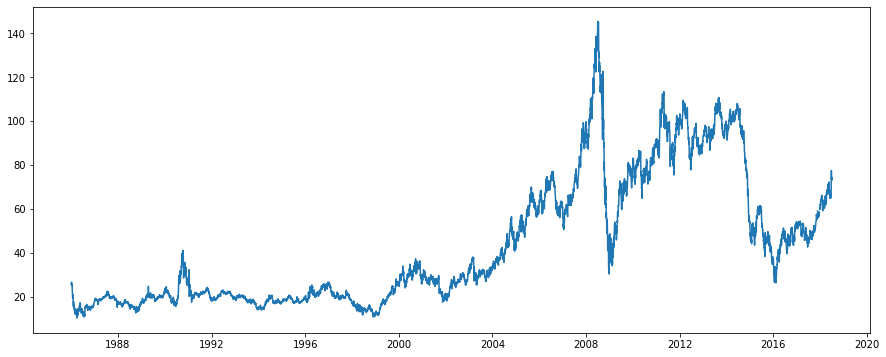

In [8]:
plot = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['date'])
price = list(df['price'])
data = pd.Series(price, time)
plt.plot(data)

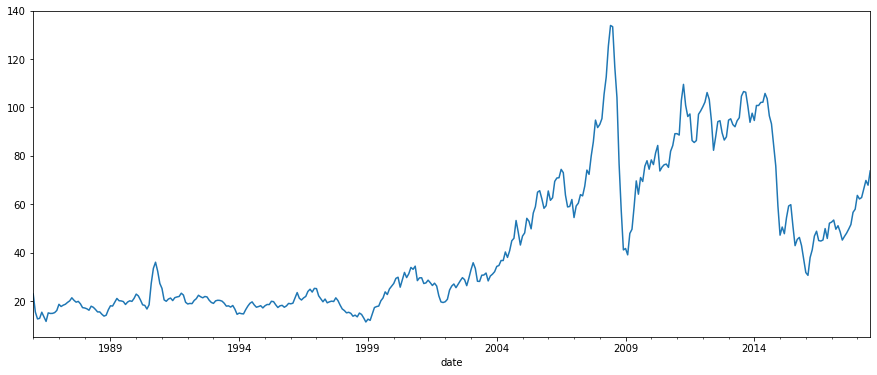

In [9]:
#Decompose the plot
df.set_index('date', inplace=True)
y = df['price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

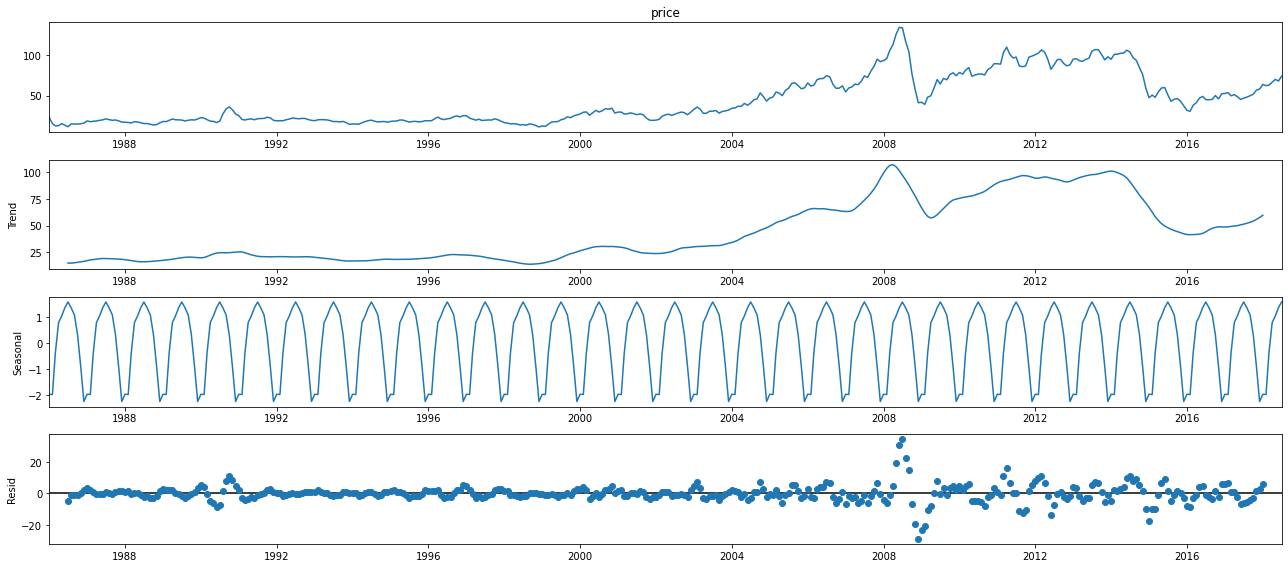

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Feature Scaling


In [11]:
df1 = df.reset_index()['price']
sc = MinMaxScaler(feature_range = (0, 1))
df1 = sc.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1.shape

(8223, 1)

## Train Test Split

In [13]:
train_size = int(len(df1) * 0.80)
test_size = len(df1) - train_size
train, test = df1[0:train_size, :], df1[train_size:len(df1), :]

In [14]:
len(test)

1645

## Creating Window

In [15]:
def dataset(df, lookback=1):
    data_x, data_y = [], []
    for i in range(len(df) - lookback - 1):
        a = df[i:(i + lookback), 0]
        data_x.append(a)
        data_y.append(df[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

time_step = 10
# Reshape into X=t and Y=t+1
X_train , Y_train = dataset(train,time_step)
X_test , Y_test = dataset(test,time_step)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
X_train.shape

(6567, 10, 1)

# **Model Building**

## Import the Model building libraries

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Initializing the Model
## Adding LSTM Layers
## Adding Output Layers

In [18]:
model = Sequential()
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(units = 10, return_sequences = True))
model.add(LSTM(units = 10))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 2,171
Trainable params: 2,171
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 1st LSTM Layer 
print(4 * 10 * (1 + 10 + 1))

480


In [ ]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


## Configure the Learning Process

In [20]:
history = model.fit(X_train, Y_train, epochs = 30, batch_size = 64,validation_data=(X_test, Y_test),verbose=2)

Epoch 1/30
103/103 - 11s - loss: 0.0147 - val_loss: nan - 11s/epoch - 110ms/step
Epoch 2/30
103/103 - 1s - loss: 4.0105e-04 - val_loss: nan - 1s/epoch - 12ms/step
Epoch 3/30
103/103 - 1s - loss: 3.9463e-04 - val_loss: nan - 1s/epoch - 11ms/step
Epoch 4/30
103/103 - 1s - loss: 3.7285e-04 - val_loss: nan - 1s/epoch - 12ms/step
Epoch 5/30
103/103 - 1s - loss: 3.6831e-04 - val_loss: nan - 1s/epoch - 11ms/step
Epoch 6/30
103/103 - 1s - loss: 3.6826e-04 - val_loss: nan - 1s/epoch - 12ms/step
Epoch 7/30
103/103 - 1s - loss: 3.6237e-04 - val_loss: nan - 1s/epoch - 10ms/step
Epoch 8/30
103/103 - 1s - loss: 3.5851e-04 - val_loss: nan - 1s/epoch - 11ms/step
Epoch 9/30
103/103 - 1s - loss: 3.5486e-04 - val_loss: nan - 952ms/epoch - 9ms/step
Epoch 10/30
103/103 - 1s - loss: 3.4703e-04 - val_loss: nan - 709ms/epoch - 7ms/step
Epoch 11/30
103/103 - 1s - loss: 3.5176e-04 - val_loss: nan - 707ms/epoch - 7ms/step
Epoch 12/30
103/103 - 1s - loss: 3.4800e-04 - val_loss: nan - 711ms/epoch - 7ms/step
Epoch 

## Train the model

In [21]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

52/52 [==============================] - 0s 3ms/step


In [22]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

## Model evaluation

In [24]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.1815635681268521
Train Root Mean Squared Error: 1.8672537689070376


ValueError: ignored

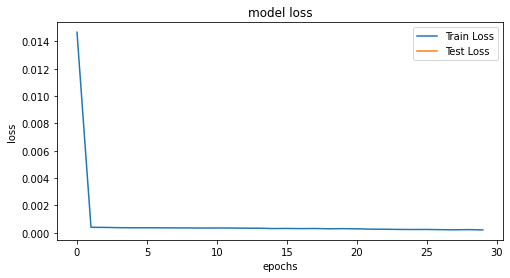

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

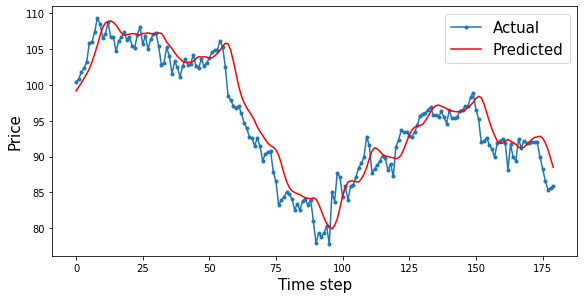

In [26]:
data = [i for i in range(180)]
plt.figure(figsize=(8,4))
plt.plot(data, Y_test[0][:180], marker='.', label="Actual")
plt.plot(data, test_predict[:,0][:180], 'r', label="Predicted")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Save the model

In [27]:
model.save("model.h5")
!tar -zcvf model.tgz model.h5

model.h5


## Test the model

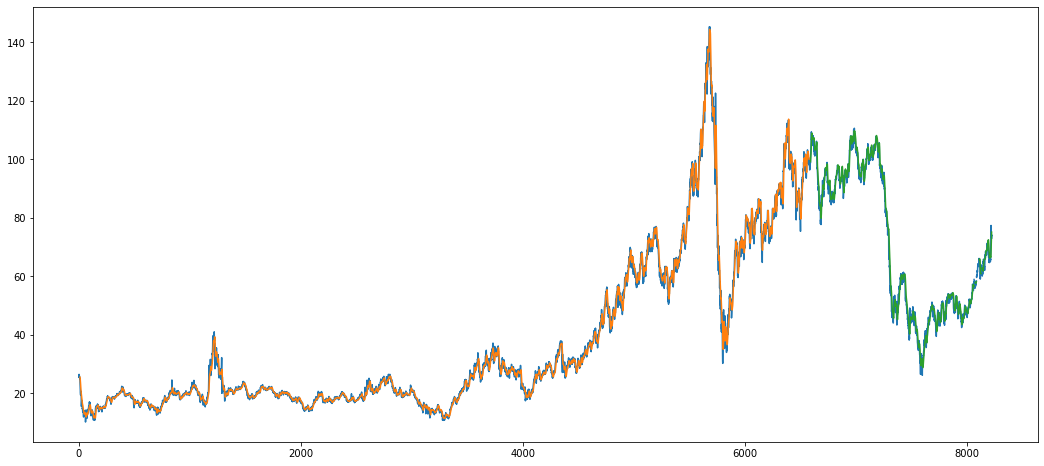

In [28]:
# Model Testing
look_back = 10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict
plt.plot(sc.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
x_input = test[len(test)-10:].reshape(1,-1)
x_input.shape

(1, 10)

In [30]:
temp_input = list(x_input[0])
temp_list = temp_input[0].tolist()

In [31]:
temp_input

[0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 nan,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [32]:
lst_output = []
n_steps = 10
i = 0
while(i<10):
  if(len(temp_input) > 10):
    x_input = np.array(temp_input[1:])
    print("Day {} Input {}".format(i,x_input),end="\n")
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} Output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print("------------------------",end="\n")
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1

Day 0 output [[nan]]
Day 1 Input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922        nan
 0.46497853 0.47038353 0.47149415        nan]
Day 1 Output [[nan]]
------------------------
Day 2 Input [0.46794017 0.47297497 0.47119799 0.47341922        nan 0.46497853
 0.47038353 0.47149415        nan        nan]
Day 2 Output [[nan]]
------------------------
Day 3 Input [0.47297497 0.47119799 0.47341922        nan 0.46497853 0.47038353
 0.47149415        nan        nan        nan]
Day 3 Output [[nan]]
------------------------
Day 4 Input [0.47119799 0.47341922        nan 0.46497853 0.47038353 0.47149415
        nan        nan        nan        nan]
Day 4 Output [[nan]]
------------------------
Day 5 Input [0.47341922        nan 0.46497853 0.47038353 0.47149415        nan
        nan        nan        nan        nan]
Day 5 Output [[nan]]
------------------------
Day 6 Input [       nan 0.46497853 0.47038353 0.47149415        nan        nan
        nan        nan        nan        nan]